NOTE A TYPO: technically everything that is called "test" on this document is validation, since we are using the result to choose the best model, which introduces bias.

In [ ]:
# Seeger Zou
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd drive/MyDrive/Fall22/ML/project/

/content/drive/MyDrive/Fall22/ML/project


In [51]:
# utilities
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import logging
import scipy

# sklearn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn.kernel_approximation import Nystroem

# tensorflow for neural networks
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Helper function for plotting

In [52]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## Prepare dataset

### Looking at the dataset

In [4]:
!egrep -c false classifier_examples_test.json
!egrep -c true classifier_examples_test.json # 53646 total
# 4:6 false:true

22100
31546


In [5]:
!egrep -c false classifier_examples_train.json
!egrep -c true classifier_examples_train.json # 482817 total
# 536463 examples for both train and test, 9: 1

197910
284907


Total 536463 examples, Class balance:\
220010 false\
316453 true\
4:6


Text(0.5, 1.0, 'Class Balance')

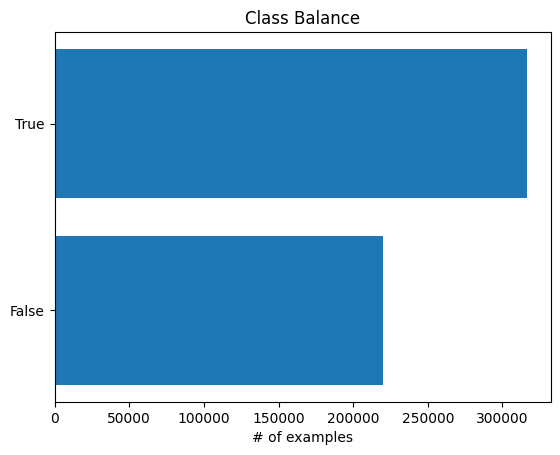

In [15]:
plt.rcdefaults()
fig, ax = plt.subplots()
cat = ['True', 'False']
pos = np.arange(len(cat))
data = [316453, 220010]
ax.barh(cat, data, align='center')
ax.invert_yaxis()
ax.set_xlabel('# of examples')
ax.set_title('Class Balance')

In [ ]:
!ls -lrt

total 76437
-rw------- 1 root root  7811063 Jul 26  2021 classifier_examples_train.json
-rw------- 1 root root 70408113 Jul 26  2021 classifier_examples_test.json
-rw------- 1 root root    30929 Jul 28  2021 glue.py
-rw------- 1 root root    19463 Jul 28  2021 run_glue_no_trainer.py
-rw------- 1 root root        0 Jul 28  2021 log_train_glue_6046456_4294967294.out
-rw------- 1 root root      227 Jul 28  2021 log_train_glue_6046456_4294967294.err


In [4]:
ftrain = open("classifier_examples_train.json")
ftest = open("classifier_examples_test.json")
trainfile = json.load(ftrain)
testfile = json.load(ftest)

trainfile[0]

{'title': 'What parking is offered?',
 'body': 'It offers off street, street, and validated parking.',
 'label': 'true'}

In [5]:
X_train = []
X_test = []
Y_train = []
Y_test = []

# Encoding
for example in trainfile:
    X_train.append(example['title'] + ' ' + example['body'])
    Y_train.append(1 if example['label'] == 'true' else 0)

for example in testfile:
    X_test.append(example['title'] + ' ' + example['body'])
    Y_test.append(1 if example['label'] == 'true' else 0)

X_train[0]

'What parking is offered? It offers off street, street, and validated parking.'

In [6]:
# For time and space complexity, sample 9:1 from 10k examples
X_train = X_train[:9000]
Y_train = Y_train[:9000]
X_test = X_test[:1000]
Y_test = Y_test[:1000]

X_train[0]

'What parking is offered? It offers off street, street, and validated parking.'

In [35]:
# Checking the distribution in the new sampling
true_count = 0
false_count = 0

for ex in Y_train:
    if ex==1:
        true_count+=1
    else:
        false_count+=1
print(true_count)
print(false_count)

5370
3630


Text(0.5, 1.0, 'New Class Balance')

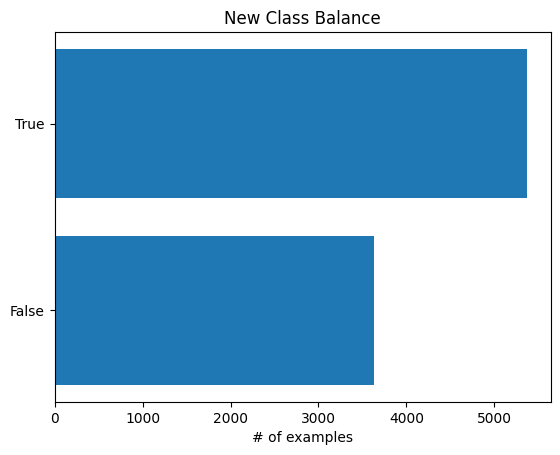

In [37]:
plt.rcdefaults()
fig, ax = plt.subplots()
cat = ['True', 'False']
pos = np.arange(len(cat))
data = [5370, 3630]
ax.barh(cat, data, align='center')
ax.invert_yaxis()
ax.set_xlabel('# of examples')
ax.set_title('New Class Balance')

Still 6:4 true:false

### Feature Extraction/Weighing/Transformation
choose 1 below

In [230]:
# checking
len(X_train),len(X_test)

(9000, 1000)

In [231]:
# Binary
tokenizer = CountVectorizer(binary=True, max_df = 0.95)

In [95]:
# Regular counts
tokenizer = CountVectorizer(binary=False, max_df = 0.95)

In [193]:
# Term frequency idf
tokenizer = TfidfVectorizer(use_idf=True, max_df=0.95)

Continue running here:

In [232]:
tokenizer.fit(X_train)
X_train_tokenized = tokenizer.transform(X_train)
X_test_tokenized = tokenizer.transform(X_test)

In [220]:
# Looking into the tokenized data and the nonzero values
for elem in X_train_tokenized[0].toarray()[0]:
    if elem.any()!=0:
        print(elem)

1
1
1
1
1
1
1
1
1
1


In [64]:
# optional, can check the sparsity of the matrix
# X_train_arr = np.array(X_train_tokenized)
# sparsity = 1 - np.count_nonzero(X_train_arr)/X_train_arr.size

In [233]:
# convert sparse to dense matrix for space and time efficiency
X_train_tokenized = scipy.sparse.csr_matrix.todense(X_train_tokenized)
X_test_tokenized = scipy.sparse.csr_matrix.todense(X_test_tokenized)

In [234]:
# format
X_train_tokenized = np.array(X_train_tokenized)
X_test_tokenized = np.array(X_test_tokenized)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [ ]:
# vocab of the tokenizer
tokenizer.vocabulary_

## Feature Scaling

Depending on which model and which method of training, some may not converge given this dataset. Feature scaling is sometimes necessary here. Below are some scalers to play around.

In [198]:
# standard scaler
scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train_tokenized)

In [41]:
# maxabs scaler, not used
scaler = preprocessing.MaxAbsScaler().fit(X_train_tokenized)

Continue running here after you've chosen your scaler.

In [199]:
X_train_tokenized = scaler.transform(X_train_tokenized)
X_test_tokenized = scaler.transform(X_test_tokenized)

In [200]:
# Looking at data after scaling
print(X_train_tokenized)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Logistic Regression

In [133]:
log_reg = LogisticRegression(verbose=1, solver='liblinear', random_state=0, C=5, penalty='l2', max_iter=1000)
log_model = log_reg.fit(X_train_tokenized,Y_train)

[LibLinear]

### Unscaled binary

liblinear C=0.001 l2 reg max_iter=1000

In [63]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.74      0.05      0.10       443
           1       0.57      0.99      0.72       557

    accuracy                           0.57      1000
   macro avg       0.65      0.52      0.41      1000
weighted avg       0.64      0.57      0.44      1000



liblinear C=5 l2 reg max_iter=1000

In [54]:
# BEST
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       443
           1       0.84      0.95      0.89       557

    accuracy                           0.87      1000
   macro avg       0.88      0.86      0.86      1000
weighted avg       0.88      0.87      0.87      1000



liblinear C=100000 max_iter=1000

In [59]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.89      0.75      0.82       443
           1       0.82      0.93      0.87       557

    accuracy                           0.85      1000
   macro avg       0.86      0.84      0.84      1000
weighted avg       0.86      0.85      0.85      1000



### Scaled Binary

C=0.001

In [79]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.82      0.60      0.69       443
           1       0.74      0.89      0.81       557

    accuracy                           0.76      1000
   macro avg       0.78      0.75      0.75      1000
weighted avg       0.77      0.76      0.76      1000



C=5

In [77]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       443
           1       0.82      0.93      0.87       557

    accuracy                           0.85      1000
   macro avg       0.86      0.84      0.84      1000
weighted avg       0.85      0.85      0.85      1000



C=100000

In [81]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       443
           1       0.82      0.93      0.87       557

    accuracy                           0.85      1000
   macro avg       0.86      0.84      0.84      1000
weighted avg       0.85      0.85      0.84      1000



### Unscaled Count

C=0.001

In [93]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.70      0.09      0.16       443
           1       0.57      0.97      0.72       557

    accuracy                           0.58      1000
   macro avg       0.63      0.53      0.44      1000
weighted avg       0.63      0.58      0.47      1000



C=5

In [91]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.71      0.51      0.59       443
           1       0.68      0.83      0.75       557

    accuracy                           0.69      1000
   macro avg       0.69      0.67      0.67      1000
weighted avg       0.69      0.69      0.68      1000



C=100000

In [89]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.70      0.51      0.59       443
           1       0.68      0.83      0.75       557

    accuracy                           0.69      1000
   macro avg       0.69      0.67      0.67      1000
weighted avg       0.69      0.69      0.68      1000



### Scaled Count

C=0.001

In [103]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.72      0.46      0.56       443
           1       0.67      0.86      0.75       557

    accuracy                           0.68      1000
   macro avg       0.69      0.66      0.66      1000
weighted avg       0.69      0.68      0.67      1000



C=5

In [105]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.70      0.51      0.59       443
           1       0.68      0.82      0.74       557

    accuracy                           0.69      1000
   macro avg       0.69      0.67      0.67      1000
weighted avg       0.69      0.69      0.68      1000



C=100000

In [107]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.70      0.51      0.59       443
           1       0.68      0.83      0.75       557

    accuracy                           0.69      1000
   macro avg       0.69      0.67      0.67      1000
weighted avg       0.69      0.69      0.68      1000



### Unscaled Tfidf

C=0.001

In [119]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       443
           1       0.56      1.00      0.72       557

    accuracy                           0.56      1000
   macro avg       0.28      0.50      0.36      1000
weighted avg       0.31      0.56      0.40      1000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C=5

In [117]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71       443
           1       0.75      0.89      0.81       557

    accuracy                           0.77      1000
   macro avg       0.78      0.76      0.76      1000
weighted avg       0.78      0.77      0.77      1000



C=100000

In [115]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       443
           1       0.79      0.90      0.84       557

    accuracy                           0.81      1000
   macro avg       0.82      0.80      0.81      1000
weighted avg       0.82      0.81      0.81      1000



### Scaled Tfidf

C=0.001

In [123]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.71      0.52      0.60       443
           1       0.68      0.83      0.75       557

    accuracy                           0.69      1000
   macro avg       0.70      0.67      0.68      1000
weighted avg       0.70      0.69      0.68      1000



C=5

In [125]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       443
           1       0.79      0.90      0.84       557

    accuracy                           0.81      1000
   macro avg       0.82      0.80      0.80      1000
weighted avg       0.82      0.81      0.81      1000



C=100000

In [127]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       443
           1       0.79      0.90      0.84       557

    accuracy                           0.81      1000
   macro avg       0.82      0.80      0.81      1000
weighted avg       0.82      0.81      0.81      1000



### Conclusion: Logistic Regression
Let's play around with the best one: binary unscaled, C=5 with 0.87 accuracy.

In [134]:
pred_test = log_model.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       443
           1       0.84      0.95      0.89       557

    accuracy                           0.87      1000
   macro avg       0.88      0.86      0.86      1000
weighted avg       0.88      0.87      0.87      1000



In [140]:
log_model.predict(tokenizer.transform(["Does it offer happy hours? It does not allow children below 6."]))

array([0])

In [159]:
log_model.predict(tokenizer.transform(["Does it offer a gym? No, it does not have happy hours."]))

array([1])

In [160]:
log_model.predict(tokenizer.transform(["Does it offer a gym on site? No, it does not have happy hours."]))

array([0])

In [142]:
log_model.predict(tokenizer.transform(["Is there a gym? No, it does not have happy hours."]))

array([1])

Remark: With the larger dataset, Logistic Regression accuracy = 0.90 with unscaled binary

## SVM

Too much data when it comes to svms. Need to take sample. Possible methods to work around it: Trying to use Nystroem to estimate kernel and speed up SVC training, failed. This is why we ultimately used the 9000:1000 data split for all the models.

In [16]:
# Normalize data?
# X_train_normalized = preprocessing.normalize(X_train_tokenized, norm='l2')
# X_test_normalized = preprocessing.normalize(X_test_tokenized, norm='l2')

feature_map_nystroem = Nystroem(gamma=.2, random_state=1, n_components=300)
X_train_nystroem = feature_map_nystroem.fit_transform(X_train_tokenized)
X_test_nystroem = feature_map_nystroem.transform(X_test_tokenized)

Model choices:

In [24]:
# Linear kernel
support_vec_machine = svm.LinearSVC()

In [18]:
# Solving the convergence issue
support_vec_machine = svm.LinearSVC(max_iter=2000)

In [223]:
# Main function
support_vec_machine = svm.SVC(C=5,kernel='linear', gamma='auto')

Continue running here.

In [224]:
support_vec_machine.fit(X_train_tokenized, Y_train)

SVC(C=5, gamma='auto', kernel='linear')

### Nystroem + LinearSVC
Let's try the nystroem approximation first with LinearSVC() to see if these tricks can run our huge dataset. Result is not good.

In [19]:
support_vec_machine.fit(X_train_nystroem, Y_train)

LinearSVC()

In [20]:
support_vec_machine.score(X_train_nystroem,Y_train)

0.774442490633097

In [21]:
support_vec_machine.score(X_test_nystroem,Y_test)

0.7742236140625582

Now we can try without the approximation

In [26]:
support_vec_machine.fit(X_train_tokenized, Y_train)

LinearSVC(max_iter=2000)

In [27]:
support_vec_machine.score(X_train_tokenized,Y_train)

0.901337359703573

In [28]:
support_vec_machine.score(X_test_tokenized,Y_test)

0.8998620586809828

Now try with feature scaling

In [19]:
support_vec_machine.fit(X_train_scaled, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=5000)

In [20]:
support_vec_machine.score(X_train_scaled,Y_train)

0.8968242626088145

In [21]:
support_vec_machine.score(X_test_scaled,Y_test)

0.8958729448607539

### Deciding to go with smaller dataset

After sampling 9000:1000 train:test data\
Just with binary tokenized data, result with different SVCs

### Unscaled Binary

With C=5 for all, Linear

In [169]:
# BEST
pred_test = support_vec_machine.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       443
           1       0.83      0.95      0.89       557

    accuracy                           0.86      1000
   macro avg       0.88      0.85      0.86      1000
weighted avg       0.87      0.86      0.86      1000



Poly

In [173]:
pred_test = support_vec_machine.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       443
           1       0.56      1.00      0.72       557

    accuracy                           0.56      1000
   macro avg       0.28      0.50      0.36      1000
weighted avg       0.31      0.56      0.40      1000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF

In [176]:
pred_test = support_vec_machine.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.85      0.27      0.41       443
           1       0.62      0.96      0.76       557

    accuracy                           0.65      1000
   macro avg       0.74      0.61      0.58      1000
weighted avg       0.72      0.65      0.60      1000



### Scaled Tfidf

Linear

In [192]:
pred_test = support_vec_machine.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       443
           1       0.80      0.92      0.85       557

    accuracy                           0.82      1000
   macro avg       0.83      0.81      0.82      1000
weighted avg       0.83      0.82      0.82      1000



Poly

In [189]:
pred_test = support_vec_machine.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.77      0.26      0.39       443
           1       0.62      0.94      0.74       557

    accuracy                           0.64      1000
   macro avg       0.69      0.60      0.57      1000
weighted avg       0.69      0.64      0.59      1000



RBF

In [186]:
pred_test = support_vec_machine.predict(X_test_tokenized)
print(metrics.classification_report(Y_test,pred_test))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       443
           1       0.81      0.92      0.86       557

    accuracy                           0.84      1000
   macro avg       0.85      0.83      0.83      1000
weighted avg       0.84      0.84      0.83      1000



### Conclusion:

In [226]:
support_vec_machine.predict(scipy.sparse.csr_matrix.todense(tokenizer.transform(["Does it offer happy hours? It does not allow children below 6."])))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([0])

In [227]:
support_vec_machine.predict(scipy.sparse.csr_matrix.todense(tokenizer.transform(["Does it offer a gym? No, it does not have happy hours."])))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([1])

In [228]:
support_vec_machine.predict(scipy.sparse.csr_matrix.todense(tokenizer.transform(["Does it offer a gym on site? No, it does not have happy hours."])))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([0])

In [229]:
support_vec_machine.predict(scipy.sparse.csr_matrix.todense(tokenizer.transform(["Is there a gym? No, it does not have happy hours."])))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([1])

## Neural Networks

In [67]:
X_train_tokenized.shape,X_train_tokenized.reshape(-1,1).shape

((482817, 2284), (1102754028, 1))

Choosing the model

In [236]:
# 3 layers, no reg
model = tf.keras.Sequential([
                            tf.keras.layers.Dense(128,activation='relu',input_shape=(X_train_tokenized.shape[1],)),
                            tf.keras.layers.Dense(32,activation='relu'),
                            tf.keras.layers.Dense(2,activation='softmax')
])

In [205]:
# 3 layers, l2 reg
model = tf.keras.Sequential([
                            tf.keras.layers.Dense(128,activation='relu',input_shape=(X_train_tokenized.shape[1],), kernel_regularizer=regularizers.L2(1e-4)),
                            tf.keras.layers.Dense(32,activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
                            tf.keras.layers.Dense(2,activation='softmax', kernel_regularizer=regularizers.L2(1e-4))
])

In [209]:
# 3 layers, dropout
model = tf.keras.Sequential([
                            tf.keras.layers.Dense(128,activation='relu',input_shape=(X_train_tokenized.shape[1],)),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(32,activation='relu'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(2,activation='softmax')
])

Summary

In [237]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               211712    
                                                                 
 dense_22 (Dense)            (None, 32)                4128      
                                                                 
 dense_23 (Dense)            (None, 2)                 66        
                                                                 
Total params: 215,906
Trainable params: 215,906
Non-trainable params: 0
_________________________________________________________________


### Unscaled Binary

3 layers without any regularization:

In [16]:
# BEST @ epoch 9/10
history = model.fit(X_train_tokenized, Y_train, epochs=10, validation_data=(X_test_tokenized, Y_test), verbose=2)

Epoch 1/10
282/282 - 3s - loss: 0.5161 - accuracy: 0.7346 - val_loss: 0.4017 - val_accuracy: 0.8300 - 3s/epoch - 10ms/step
Epoch 2/10
282/282 - 2s - loss: 0.2468 - accuracy: 0.9102 - val_loss: 0.2947 - val_accuracy: 0.8800 - 2s/epoch - 6ms/step
Epoch 3/10
282/282 - 2s - loss: 0.1100 - accuracy: 0.9651 - val_loss: 0.2640 - val_accuracy: 0.9040 - 2s/epoch - 6ms/step
Epoch 4/10
282/282 - 2s - loss: 0.0612 - accuracy: 0.9814 - val_loss: 0.2387 - val_accuracy: 0.9280 - 2s/epoch - 6ms/step
Epoch 5/10
282/282 - 2s - loss: 0.0314 - accuracy: 0.9913 - val_loss: 0.2442 - val_accuracy: 0.9330 - 2s/epoch - 6ms/step
Epoch 6/10
282/282 - 2s - loss: 0.0226 - accuracy: 0.9940 - val_loss: 0.2711 - val_accuracy: 0.9280 - 2s/epoch - 6ms/step
Epoch 7/10
282/282 - 2s - loss: 0.0113 - accuracy: 0.9973 - val_loss: 0.3092 - val_accuracy: 0.9280 - 2s/epoch - 6ms/step
Epoch 8/10
282/282 - 1s - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.2423 - val_accuracy: 0.9450 - 1s/epoch - 5ms/step
Epoch 9/10
282/282 - 1s

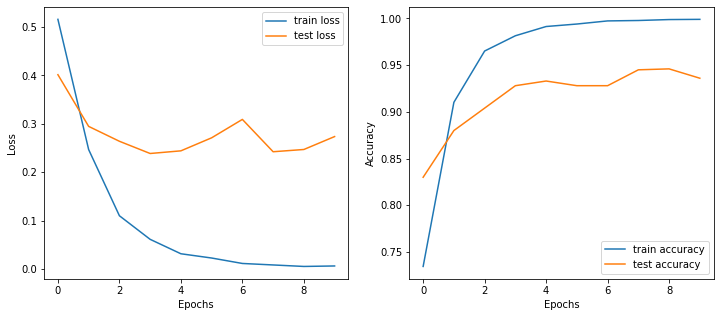

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'test loss']);
ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train accuracy', 'test accuracy']);

3 layers with L2 regularization:

In [23]:
history = model.fit(X_train_tokenized, Y_train, epochs=10, validation_data=(X_test_tokenized, Y_test), verbose=2)

Epoch 1/10
282/282 - 3s - loss: 0.5256 - accuracy: 0.7451 - val_loss: 0.4270 - val_accuracy: 0.8320 - 3s/epoch - 10ms/step
Epoch 2/10
282/282 - 2s - loss: 0.2582 - accuracy: 0.9100 - val_loss: 0.2991 - val_accuracy: 0.8850 - 2s/epoch - 7ms/step
Epoch 3/10
282/282 - 2s - loss: 0.1416 - accuracy: 0.9629 - val_loss: 0.2824 - val_accuracy: 0.9000 - 2s/epoch - 7ms/step
Epoch 4/10
282/282 - 1s - loss: 0.0892 - accuracy: 0.9797 - val_loss: 0.2888 - val_accuracy: 0.9170 - 1s/epoch - 5ms/step
Epoch 5/10
282/282 - 1s - loss: 0.0638 - accuracy: 0.9893 - val_loss: 0.2522 - val_accuracy: 0.9290 - 1s/epoch - 5ms/step
Epoch 6/10
282/282 - 2s - loss: 0.0525 - accuracy: 0.9917 - val_loss: 0.2952 - val_accuracy: 0.9280 - 2s/epoch - 6ms/step
Epoch 7/10
282/282 - 2s - loss: 0.0446 - accuracy: 0.9944 - val_loss: 0.3515 - val_accuracy: 0.9160 - 2s/epoch - 7ms/step
Epoch 8/10
282/282 - 2s - loss: 0.0371 - accuracy: 0.9978 - val_loss: 0.2577 - val_accuracy: 0.9370 - 2s/epoch - 7ms/step
Epoch 9/10
282/282 - 2s

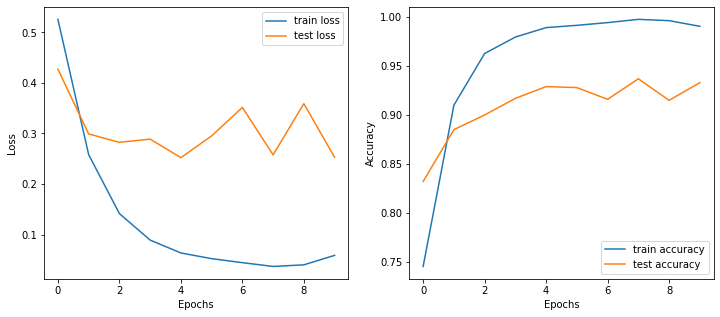

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'test loss']);
ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train accuracy', 'test accuracy']);

3 layers with dropout regularization:

In [29]:
history = model.fit(X_train_tokenized, Y_train, epochs=10, validation_data=(X_test_tokenized, Y_test), verbose=2)

Epoch 1/10
282/282 - 2s - loss: 0.5509 - accuracy: 0.7117 - val_loss: 0.4295 - val_accuracy: 0.8230 - 2s/epoch - 9ms/step
Epoch 2/10
282/282 - 2s - loss: 0.3153 - accuracy: 0.8740 - val_loss: 0.3015 - val_accuracy: 0.8810 - 2s/epoch - 5ms/step
Epoch 3/10
282/282 - 2s - loss: 0.1764 - accuracy: 0.9378 - val_loss: 0.2504 - val_accuracy: 0.9080 - 2s/epoch - 5ms/step
Epoch 4/10
282/282 - 2s - loss: 0.1107 - accuracy: 0.9640 - val_loss: 0.2635 - val_accuracy: 0.9080 - 2s/epoch - 6ms/step
Epoch 5/10
282/282 - 2s - loss: 0.0730 - accuracy: 0.9779 - val_loss: 0.2370 - val_accuracy: 0.9280 - 2s/epoch - 6ms/step
Epoch 6/10
282/282 - 2s - loss: 0.0564 - accuracy: 0.9820 - val_loss: 0.2454 - val_accuracy: 0.9260 - 2s/epoch - 6ms/step
Epoch 7/10
282/282 - 1s - loss: 0.0436 - accuracy: 0.9873 - val_loss: 0.2625 - val_accuracy: 0.9250 - 1s/epoch - 5ms/step
Epoch 8/10
282/282 - 2s - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.3375 - val_accuracy: 0.9190 - 2s/epoch - 6ms/step
Epoch 9/10
282/282 - 2s 

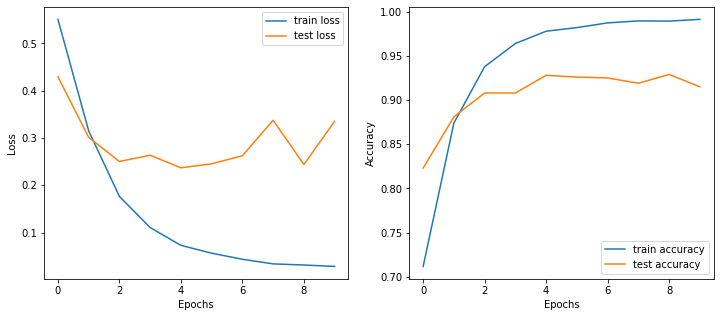

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'test loss']);
ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train accuracy', 'test accuracy']);

### Scaled Tfidf

3 layers without any regularization:

In [203]:
history = model.fit(X_train_tokenized, Y_train, epochs=10, validation_data=(X_test_tokenized, Y_test), verbose=2)

Epoch 1/10
282/282 - 2s - loss: 0.6013 - accuracy: 0.7019 - val_loss: 0.5493 - val_accuracy: 0.7400 - 2s/epoch - 9ms/step
Epoch 2/10
282/282 - 1s - loss: 0.3836 - accuracy: 0.8361 - val_loss: 0.5245 - val_accuracy: 0.7880 - 1s/epoch - 4ms/step
Epoch 3/10
282/282 - 1s - loss: 0.2690 - accuracy: 0.9020 - val_loss: 0.4781 - val_accuracy: 0.8350 - 1s/epoch - 4ms/step
Epoch 4/10
282/282 - 1s - loss: 0.1748 - accuracy: 0.9427 - val_loss: 0.4817 - val_accuracy: 0.8430 - 1s/epoch - 4ms/step
Epoch 5/10
282/282 - 1s - loss: 0.1248 - accuracy: 0.9629 - val_loss: 0.5005 - val_accuracy: 0.8460 - 1s/epoch - 4ms/step
Epoch 6/10
282/282 - 1s - loss: 0.0834 - accuracy: 0.9769 - val_loss: 0.4690 - val_accuracy: 0.8780 - 1s/epoch - 4ms/step
Epoch 7/10
282/282 - 1s - loss: 0.0677 - accuracy: 0.9783 - val_loss: 0.5128 - val_accuracy: 0.8710 - 1s/epoch - 4ms/step
Epoch 8/10
282/282 - 1s - loss: 0.0538 - accuracy: 0.9822 - val_loss: 0.5030 - val_accuracy: 0.8870 - 1s/epoch - 4ms/step
Epoch 9/10
282/282 - 1s 

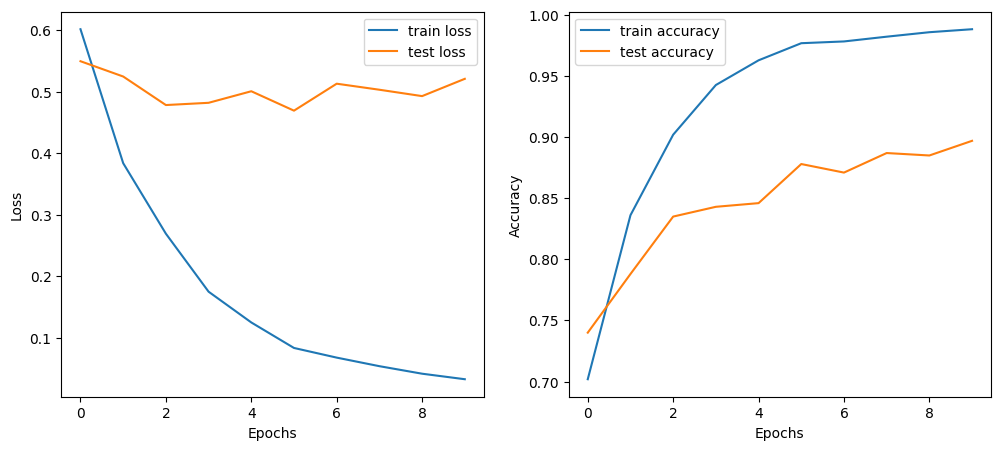

In [204]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'test loss']);
ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train accuracy', 'test accuracy']);

3 layers with L2 regularization:

In [207]:
history = model.fit(X_train_tokenized, Y_train, epochs=10, validation_data=(X_test_tokenized, Y_test), verbose=2)

Epoch 1/10
282/282 - 2s - loss: 0.5871 - accuracy: 0.7132 - val_loss: 0.5459 - val_accuracy: 0.7550 - 2s/epoch - 8ms/step
Epoch 2/10
282/282 - 1s - loss: 0.3750 - accuracy: 0.8533 - val_loss: 0.5241 - val_accuracy: 0.8020 - 1s/epoch - 5ms/step
Epoch 3/10
282/282 - 1s - loss: 0.2535 - accuracy: 0.9173 - val_loss: 0.4625 - val_accuracy: 0.8620 - 1s/epoch - 5ms/step
Epoch 4/10
282/282 - 1s - loss: 0.1751 - accuracy: 0.9501 - val_loss: 0.4650 - val_accuracy: 0.8650 - 1s/epoch - 5ms/step
Epoch 5/10
282/282 - 1s - loss: 0.1334 - accuracy: 0.9661 - val_loss: 0.4537 - val_accuracy: 0.8840 - 1s/epoch - 5ms/step
Epoch 6/10
282/282 - 1s - loss: 0.0950 - accuracy: 0.9783 - val_loss: 0.4561 - val_accuracy: 0.8820 - 1s/epoch - 5ms/step
Epoch 7/10
282/282 - 1s - loss: 0.0861 - accuracy: 0.9801 - val_loss: 0.4634 - val_accuracy: 0.8900 - 1s/epoch - 5ms/step
Epoch 8/10
282/282 - 1s - loss: 0.0768 - accuracy: 0.9832 - val_loss: 0.4335 - val_accuracy: 0.8990 - 1s/epoch - 5ms/step
Epoch 9/10
282/282 - 1s 

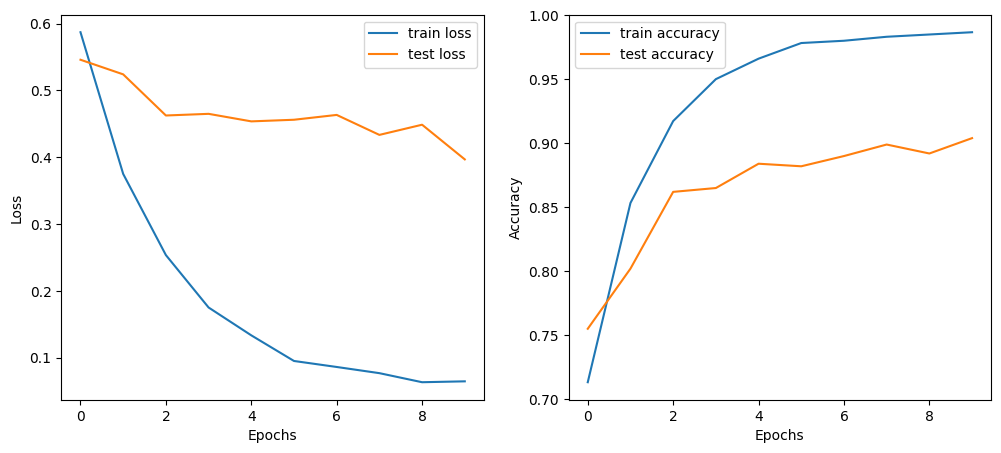

In [208]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'test loss']);
ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train accuracy', 'test accuracy']);

3 layers with dropout regularization:

In [211]:
history = model.fit(X_train_tokenized, Y_train, epochs=10, validation_data=(X_test_tokenized, Y_test), verbose=2)

Epoch 1/10
282/282 - 2s - loss: 0.6602 - accuracy: 0.6644 - val_loss: 0.5696 - val_accuracy: 0.7320 - 2s/epoch - 7ms/step
Epoch 2/10
282/282 - 1s - loss: 0.4813 - accuracy: 0.7738 - val_loss: 0.5471 - val_accuracy: 0.7630 - 1s/epoch - 4ms/step
Epoch 3/10
282/282 - 1s - loss: 0.4036 - accuracy: 0.8201 - val_loss: 0.5325 - val_accuracy: 0.7970 - 1s/epoch - 4ms/step
Epoch 4/10
282/282 - 1s - loss: 0.3483 - accuracy: 0.8472 - val_loss: 0.5255 - val_accuracy: 0.8120 - 1s/epoch - 4ms/step
Epoch 5/10
282/282 - 1s - loss: 0.2846 - accuracy: 0.8812 - val_loss: 0.5401 - val_accuracy: 0.8210 - 1s/epoch - 4ms/step
Epoch 6/10
282/282 - 1s - loss: 0.2482 - accuracy: 0.9003 - val_loss: 0.5195 - val_accuracy: 0.8480 - 1s/epoch - 4ms/step
Epoch 7/10
282/282 - 1s - loss: 0.2044 - accuracy: 0.9190 - val_loss: 0.5732 - val_accuracy: 0.8390 - 1s/epoch - 4ms/step
Epoch 8/10
282/282 - 1s - loss: 0.1757 - accuracy: 0.9357 - val_loss: 0.6093 - val_accuracy: 0.8430 - 1s/epoch - 4ms/step
Epoch 9/10
282/282 - 1s 

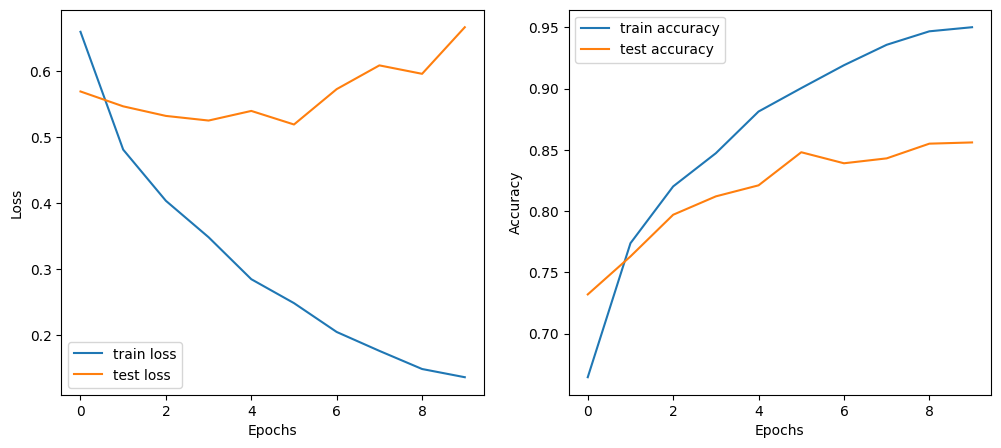

In [212]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'test loss']);
ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train accuracy', 'test accuracy']);

### Conclusion:

In [238]:
history = model.fit(X_train_tokenized, Y_train, epochs=10, validation_data=(X_test_tokenized, Y_test), verbose=2)

Epoch 1/10
282/282 - 2s - loss: 0.5071 - accuracy: 0.7454 - val_loss: 0.4002 - val_accuracy: 0.8320 - 2s/epoch - 7ms/step
Epoch 2/10
282/282 - 1s - loss: 0.2369 - accuracy: 0.9119 - val_loss: 0.2926 - val_accuracy: 0.8880 - 1s/epoch - 4ms/step
Epoch 3/10
282/282 - 1s - loss: 0.1118 - accuracy: 0.9658 - val_loss: 0.2387 - val_accuracy: 0.9100 - 1s/epoch - 4ms/step
Epoch 4/10
282/282 - 1s - loss: 0.0585 - accuracy: 0.9821 - val_loss: 0.2602 - val_accuracy: 0.9130 - 1s/epoch - 4ms/step
Epoch 5/10
282/282 - 1s - loss: 0.0368 - accuracy: 0.9896 - val_loss: 0.3355 - val_accuracy: 0.9080 - 1s/epoch - 4ms/step
Epoch 6/10
282/282 - 1s - loss: 0.0195 - accuracy: 0.9951 - val_loss: 0.2712 - val_accuracy: 0.9300 - 1s/epoch - 4ms/step
Epoch 7/10
282/282 - 1s - loss: 0.0147 - accuracy: 0.9959 - val_loss: 0.2964 - val_accuracy: 0.9340 - 1s/epoch - 4ms/step
Epoch 8/10
282/282 - 1s - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.3689 - val_accuracy: 0.9200 - 1s/epoch - 4ms/step
Epoch 9/10
282/282 - 1s 

In [239]:
model.predict(scipy.sparse.csr_matrix.todense(tokenizer.transform(["Does it offer happy hours? It does not allow children below 6."])))

1/1 [==============================] - 0s 108ms/step


array([[0.07494579, 0.9250542 ]], dtype=float32)

In [240]:
model.predict(scipy.sparse.csr_matrix.todense(tokenizer.transform(["Does it offer a gym? No, it does not have happy hours."])))

1/1 [==============================] - 0s 55ms/step


array([[0.02371382, 0.9762862 ]], dtype=float32)

In [247]:
model.predict(scipy.sparse.csr_matrix.todense(tokenizer.transform(["Does it offer a gym on site? No, it does not have happy hours."])))

1/1 [==============================] - 0s 19ms/step


array([[0.05099352, 0.9490065 ]], dtype=float32)

In [243]:
model.predict(scipy.sparse.csr_matrix.todense(tokenizer.transform(["Is there a gym? No, it does not have happy hours."])))

1/1 [==============================] - 0s 19ms/step


array([[9.1008429e-04, 9.9908996e-01]], dtype=float32)

## Others: BERT Transformers model using pytorch

In [257]:
%env HOME=/content/drive/MyDrive/
#Enter Model Environment
%cd ~/Research/ner/text_classifier/model_env/dstc10
!ls -lrt

env: HOME=/content/drive/MyDrive/
/content/drive/MyDrive/Research/ner/text_classifier/model_env/dstc10
total 427984
-rw------- 1 root root       699 Jul 27  2021 config.json
-rw------- 1 root root 437990081 Jul 27  2021 pytorch_model.bin
-rw------- 1 root root         0 Aug  7  2021 merge_log.txt
-rw------- 1 root root    142175 Aug  9  2021 one_elem_cluster2.pkl
-rw------- 1 root root    121615 Aug  9  2021 one_elem_cluster1.pkl


In [258]:
import torch

model_name = "bert-base-uncased"
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [259]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.0 MB/s 
     |████████████████████████████████| 182 kB 48.7 MB/s 
     |████████████████████████████████| 7.6 MB 35.4 MB/s 


In [260]:
#Loading Tokenizer, Config, and Model from drive
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification

model_name = "bert-base-uncased"

config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
#model = AutoModel.from_pretrained("./glue_model")
model = AutoModelForSequenceClassification.from_pretrained(".")

# Set device
model.to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [261]:
#Checks for dict weight
state_dict = model.state_dict()
state_dict["bert.embeddings.word_embeddings.weight"]

tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]])

In [262]:
def _single_test(pair):
    result = tokenizer([pair], return_tensors="pt")
    result.to(device)
    model.eval()
    outputs = model(**result)
    #print("Output Dictionary Keys:\n", outputs.keys(),end='\n\n')
    #print("Sequence Logits:\n",outputs,end='\n\n')
    predictions = outputs.logits.argmax(dim=-1)
    #print('Preditions:\n',predictions,end='\n\n')
    if predictions==0:
        print('True')
    else:
        print('False')
    torch.cuda.empty_cache()

In [266]:
sentence = "Does it offer happy hours?"
body = "It does not allow children below 6."
pair = (sentence, body)
_single_test(pair)

False


In [267]:
sentence = "Does it offer a gym?"
body = " No, it does not have happy hours."
pair = (sentence, body)
_single_test(pair)

False


In [268]:
sentence = "Does it offer a gym on site?"
body = " No, it does not have happy hours."
pair = (sentence, body)
_single_test(pair)

False


In [270]:
sentence = "Is there a gym?"
body = "No, it does not have happy hours."
pair = (sentence, body)
_single_test(pair)

False


In [271]:
sentence = "Is there a gym?"
body = "Yes, there is a gym."
pair = (sentence, body)
_single_test(pair)

True


## This is the end of the document. For more information see the paper.